In this blog post, we'll have a look at the [Kaggle What's Cooking data challenge](https://www.kaggle.com/c/whats-cooking).

This competition is all about predicting which country a recipe is from, given a list of its ingredient. For example, assume you have a recipe that reads:

> plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil

Can you guess from which cuisine this is? As this recipe comes from the training set of this challenge, I can tell you that the expected answer is Southern US.

Without further ado, let's dive in. First, let us have a look at the training data.

# Exploring the training data

We'll use `pandas` to go through the data. First, let's read the json file containing the recipes and the cuisines:

In [1]:
import pandas as pd

In [2]:
df_train = pd.read_json('train.json')

Let's look at the head of the data:

In [3]:
df_train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


We can see the structure of the data: a cuisine, an id for the recipe, and the ingredients.

As a first step, let's look at the cuisines in the dataset. How many and how much of these do we have?

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

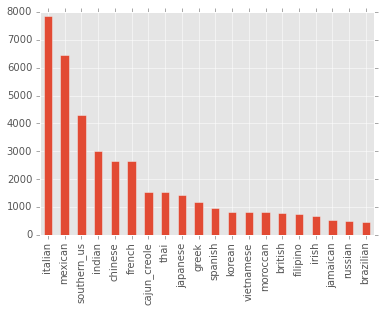

In [6]:
df_train['cuisine'].value_counts().plot(kind='bar')

As can be seen in this figure, there are a lot of Italian, Mexican and Southern US recipes, a little less of the other recipes.

To get a little insight in the data itself, we can look at a couple of recipes. In particular, we can count the most frequent ingredients for each cuisine. To do that, we can use the Python counter objects (found in the `collections` module from the standard library).

In [7]:
from collections import Counter

In [8]:
counters = {}
for cuisine in df_train['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (df_train['cuisine'] == cuisine)
    for ingredients in df_train[indices]['ingredients']:
        counters[cuisine].update(ingredients)

Let's look at a result:

In [9]:
counters['italian'].most_common(10)

[('salt', 3454),
 ('olive oil', 3111),
 ('garlic cloves', 1619),
 ('grated parmesan cheese', 1580),
 ('garlic', 1471),
 ('ground black pepper', 1444),
 ('extra-virgin olive oil', 1362),
 ('onions', 1240),
 ('water', 1052),
 ('butter', 1030)]

We can easily convert the top 10 ingredients for each cuisine to a separate dataframe for nicer viewing:

In [10]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
cajun_creole,salt,onions,garlic,green bell pepper,butter,olive oil,cayenne pepper,cajun seasoning,all-purpose flour,water
irish,salt,butter,all-purpose flour,onions,sugar,potatoes,baking soda,baking powder,milk,carrots
vietnamese,fish sauce,sugar,salt,garlic,water,carrots,soy sauce,shallots,garlic cloves,vegetable oil
chinese,soy sauce,sesame oil,salt,corn starch,sugar,garlic,water,green onions,vegetable oil,scallions
brazilian,salt,onions,olive oil,lime,water,garlic cloves,garlic,cachaca,sugar,tomatoes
indian,salt,onions,garam masala,water,ground turmeric,garlic,cumin seed,ground cumin,vegetable oil,oil
spanish,salt,olive oil,garlic cloves,extra-virgin olive oil,onions,water,tomatoes,ground black pepper,red bell pepper,pepper
southern_us,salt,butter,all-purpose flour,sugar,large eggs,baking powder,water,unsalted butter,milk,buttermilk
japanese,soy sauce,salt,mirin,sugar,water,sake,rice vinegar,vegetable oil,scallions,ginger
russian,salt,sugar,onions,all-purpose flour,sour cream,eggs,water,butter,unsalted butter,large eggs


An even better visualisation would be to have images instead of words for this visualization. We can do this by exporting the previous table to html and replacing the ingredient names with HTML image tags for the selected ingredients. This is done using regular expression matching:

In [11]:
import re

In [12]:
def repl(m):
    ingredient = m.groups()[0]
    image_path = 'img/' + ingredient + '.png'
    return '<td><img width=100 src="{}"></td>'.format(image_path)

table_with_images = re.sub("<td>([ \-\w]+)</td>", repl, top10.to_html())

We can easily display this HTML output in our notebook:

In [13]:
from IPython.display import HTML

In [16]:
HTML(table_with_images)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
cajun_creole,,,,,,,,,,
irish,,,,,,,,,,
vietnamese,,,,,,,,,,
chinese,,,,,,,,,,
brazilian,,,,,,,,,,
indian,,,,,,,,,,
spanish,,,,,,,,,,
southern_us,,,,,,,,,,
japanese,,,,,,,,,,
russian,,,,,,,,,,


This visualization allows us to determine a couple of things. For instance we can see that the top1 ingredient for each cuisine is a salty ingredient. This salty ingredient allows us to group the cuisines already:

- salt is the standard for most cuisines
- soy sauce is number one for chinese, japanese and korean cuisines
- fish sauce is number one for thai and vietnamese cuisines

Another things that is easily seen from this table is that many ingredients have more than one name:

- garlic cloves, garlic
- olive oil, extra-virgin olive oil
- ...

Jugding from this table, it can be interesting to see which ingredients among the top10 ingredients are highly specific for a certain cuisine. A way to do this is to simply count the number of times an ingredient appears in a given cuisine and divide by the total number of recipes.

To do this, we first create a new column in our dataframe by simply concatening the ingredients to a single string:

In [17]:
df_train['all_ingredients'] = df_train['ingredients'].map(";".join)

In [18]:
df_train.head()

,cuisine,id,ingredients,all_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce;black olives;grape tomatoes;ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour;ground pepper;salt;tomatoes;ground...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs;pepper;salt;mayonaise;cooking oil;green c...
3,indian,22213,"[water, vegetable oil, wheat, salt]",water;vegetable oil;wheat;salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",black pepper;shallots;cornflour;cayenne pepper...


We can now take advantage of the powerful string processing functions of pandas to check for the presence of an ingredient in a recipe:

In [20]:
df_train['all_ingredients'].str.contains('garlic cloves')

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12        True
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
39744     True
39745    False
39746    False
39747    False
39748    False
39749    False
39750    False
39751    False
39752    False
39753     True
39754     True
39755    False
39756    False
39757     True
39758    False
39759    False
39760    False
39761     True
39762    False
39763    False
39764    False
39765    False
39766    False
39767    False
39768    False
39769    False
39770    False
39771    False
39772    False
39773    False
Name: all_ingredients, dtype: bool

This can be used to group our recipes by the presence of that ingredient:

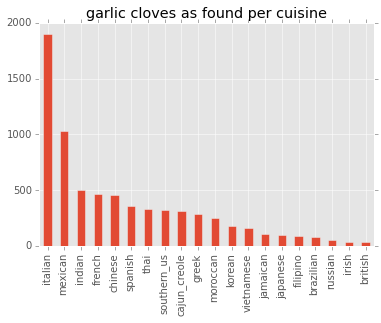

In [27]:
indices = df_train['all_ingredients'].str.contains('garlic cloves')
df_train[indices]['cuisine'].value_counts().plot(kind='bar',
                                                 title='garlic cloves as found per cuisine')

However, we have to keep in mind that there are a lot of Italian recipes in our database, so it's appropriate to divide by that number before presenting the result:

/Users/kappamaki/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


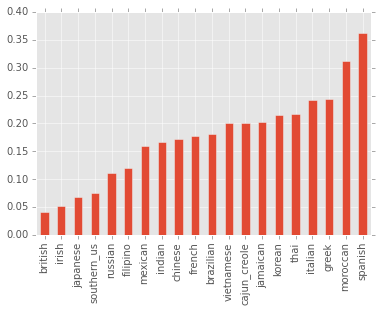

In [36]:
relative_freq = (df_train[indices]['cuisine'].value_counts() / df_train['cuisine'].value_counts())
relative_freq.sort(inplace=True)
relative_freq.plot(kind='bar')

This way of looking at the data lets us see which countries use garlic cloves a lot in the recipes found in the database. As expected, mediterranean and asian cuisines are at the top, and british at the bottom.

We can do this sort of plot for all top 10 ingredients. First let's determine the unique ingredients:

In [42]:
import numpy as np
unique = np.unique(top10.values.ravel())
unique

array(['all-purpose flour', 'avocado', 'baking powder', 'baking soda',
       'black pepper', 'butter', 'buttermilk', 'cachaca',
       'cajun seasoning', 'carrots', 'cayenne pepper', 'chili powder',
       'coconut milk', 'corn starch', 'corn tortillas', 'cumin seed',
       'dried oregano', 'dried thyme', 'eggs', 'extra-virgin olive oil',
       'feta cheese crumbles', 'fish sauce', 'fresh lemon juice',
       'fresh lime juice', 'garam masala', 'garlic', 'garlic cloves',
       'ginger', 'grated parmesan cheese', 'green bell pepper',
       'green onions', 'ground allspice', 'ground black pepper',
       'ground cinnamon', 'ground cumin', 'ground ginger',
       'ground turmeric', 'jalapeno chilies', 'large eggs', 'lime', 'milk',
       'mirin', 'oil', 'olive oil', 'onions', 'paprika', 'pepper',
       'potatoes', 'red bell pepper', 'rice vinegar', 'sake', 'salt',
       'scallions', 'sesame oil', 'sesame seeds', 'shallots', 'sour cream',
       'soy sauce', 'sugar', 'tomatoes', 'un

Turns out we can fit this in a 8 by 8 subplot diagram:

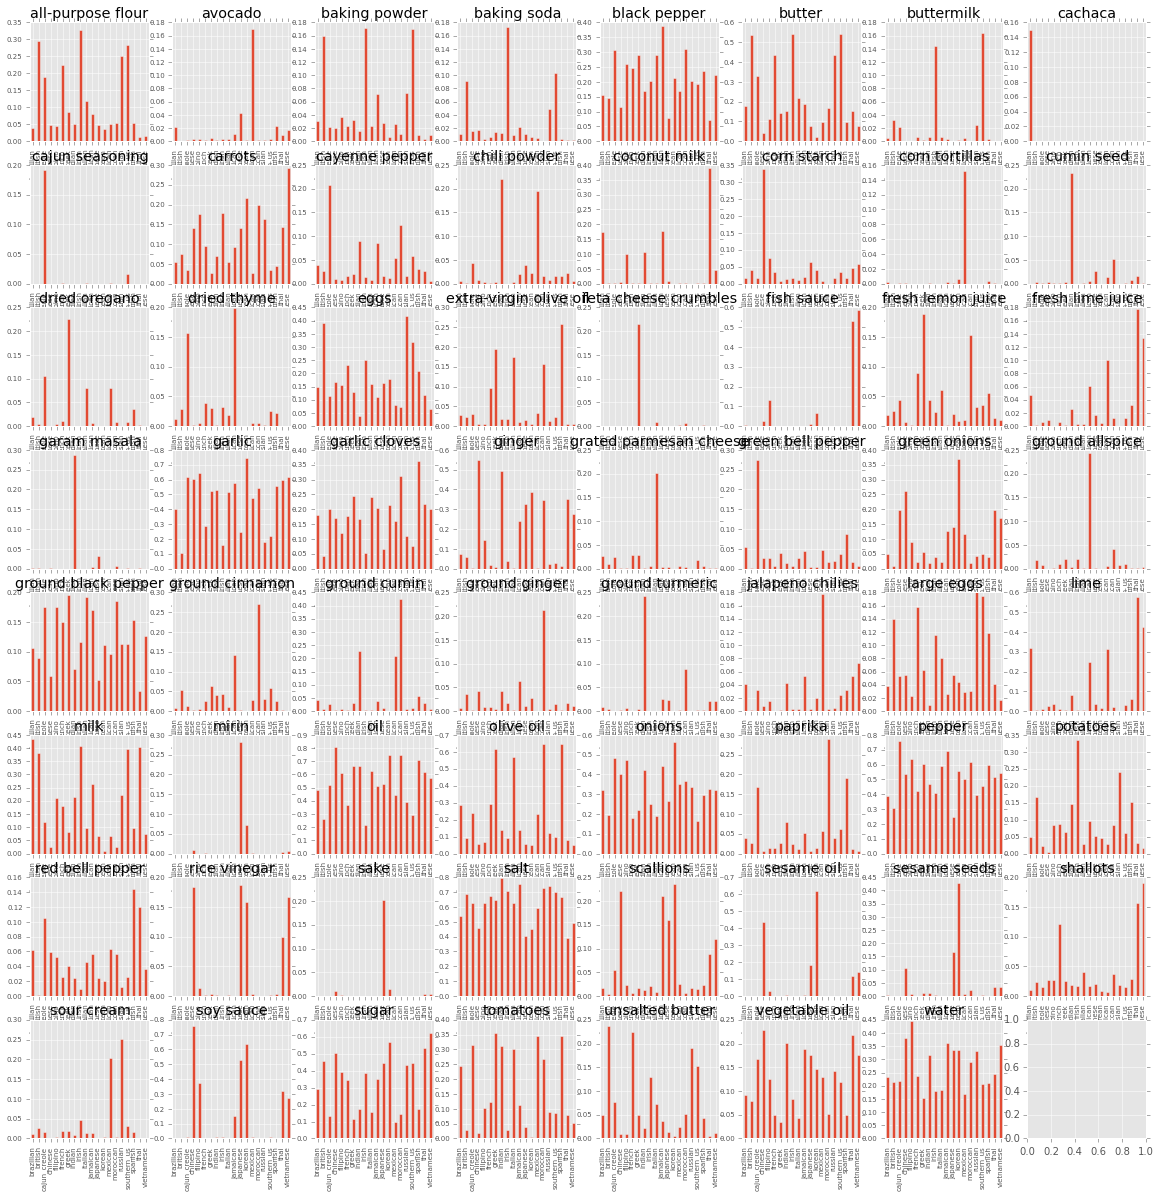

In [51]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for ingredient, ax_index in zip(unique, range(64)):
    indices = df_train['all_ingredients'].str.contains(ingredient)
    relative_freq = (df_train[indices]['cuisine'].value_counts() / df_train['cuisine'].value_counts())
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)

The previous diagram, even if it's not very clear, allows us to spot ingredients which have a high degree of uniqueness. Among them, I'd list:

- soy sauce (asian cuisine)
- sake (Japanese)
- sesame oil (asian cuisine)
- feta cheese crumbs (Greek)
- garam masala (Indian)
- ground ginger (Morrocan)
- avocado (Mexican)

Others are quite common:

- salt
- oil
- pepper
- sugar

This nicely concludes our data exploration. At the same time, it allows us to form a little intuition about how we could categorize a recipe's cuisine based on the ingredients:

- are there highly specific ingredients in the recipe that clearly point it to a given country?

In the next section, we will train a logistic regression classifier on the data we have analyzed so far and look at the results.

# Training a logistic regression classifier 

We will use scikit-learn to perform our classification. First, we will need to encode our features to a matrix that the machine learning algorithms in scikit learn can use. This is done using a count vectorizer:

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

We can conveniently tell the count vectorizer which features it should accept and let him build the matrix with 1s and 0s when ingredients are present in a single step as follows:

In [58]:
cv = CountVectorizer()

In [64]:
X = cv.fit_transform(df_train['all_ingredients'].values)

We can check the shape of that matrix:

In [65]:
X.shape

(39774, 3010)

We see that the vectorizer has retained 3010 ingredients and processed the 40 000 recipes in the training dataset. We can easily access the features to check them using the vectorizers properties (which is a dictionary):

In [73]:
print(list(cv.vocabulary_.keys())[:100])

['toast', 'accompaniment', 'cho', 'lb', 'pots', 'bought', 'champagne', 'parmesan', 'frostings', 'blackening', 'wildflower', 'jelli', 'spinach', 'saltines', 'strawberries', 'crocker', 'abbamele', 'farofa', 'coulis', 'drum', 'jalape', 'scallops', 'thawed', 'wok', 'lobsters', 'dry', 'pit', 'banh', 'purple', 'negi', 'clover', 'sorrel', 'shallots', 'mam', 'salsify', 'hubbard', 'mince', 'uncooked', 'rubbed', 'chip', 'martha', 'romano', '14', 'colada', 'sturgeon', 'chioggia', 'la', 'gochugaru', 'chops', 'racks', 'helix', 'mini', 'vital', 'belly', 'field', 'whites', 'carrots', 'lime', 'knockwurst', 'cooked', 'tikka', 'pumpkin', 'gyoza', 'harissa', 'prosciutto', 'quinces', 'tomatillo', 'ricard', 'best', 'jaggery', 'brioche', 'weed', 'cocktail', 'lap', 'ahi', 'bucatini', 'rib', 'pumpkinseed', 'pepitas', 'poppyseeds', 'hot', 'drummettes', 'kokum', 'prune', 'jujubes', 'steamed', 'turtle', 'candied', 'walnuts', 'self', 'quarters', 'fillets', 'vietnamese', 'sausages', 'mian', 'seaweed', 'rouille', '

Each feature gets assigned a column number, which is assigned a 1 or a 0 depending on the presence or not of the ingredient.

Now that we have our feature matrix, we still need to encode the labels that represent the cuisine of each recipe. This is done with a label encoder:

In [74]:
from sklearn.preprocessing import LabelEncoder

In [75]:
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)

The variable `y` is now a vector with number instead of strings for each cuisine:

In [76]:
y[:100]

array([ 6, 16,  4,  7,  7, 10, 17,  9, 13,  9,  9,  3,  9, 13,  9,  7,  1,
        9, 18, 19, 18, 13, 16,  3,  9,  3,  2,  9,  3, 13,  9,  2, 13, 18,
        9,  2,  9,  4, 16, 16,  9,  0, 13,  7, 13,  3,  5, 16, 16, 16, 11,
       16,  9, 16,  9, 10, 11,  7,  9,  8, 18, 18,  7, 10,  9, 18, 12,  5,
        5, 16, 17,  7, 14,  9,  9, 14, 14, 19, 11, 13,  2, 16,  5,  7,  7,
        9,  9,  7, 12, 17,  9, 16, 16,  6, 13, 13, 16,  7,  9,  9])

We can check the result by inspecting the encoders classes:

In [77]:
enc.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

Let's now train a logistic regression on the dataset. We'll split the dataset so that we can also test our classifier on data that he hasn't seen before:

In [78]:
from sklearn.cross_validation import train_test_split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now, let's train a logistic regression:

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We can evaluate our classifier on our test set:

In [82]:
logistic.score(X_test, y_test)

0.78152105593966059

It turns out it performs quite nicely, with a 78% accuracy.

However, this doesn't tell the whole story about what's happening. Let's inspect the classification results using a confusion matrix.

# Inspecting the classification results using a confusion matrix 

A confusion matrix allows us to see the confusion the classifier makes. It should be read column by column. In each column, one sees the recipes the classifier considered to be one cuisine. Looking at the color in each square one can see the relative accuracy of that classification.

/Users/kappamaki/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


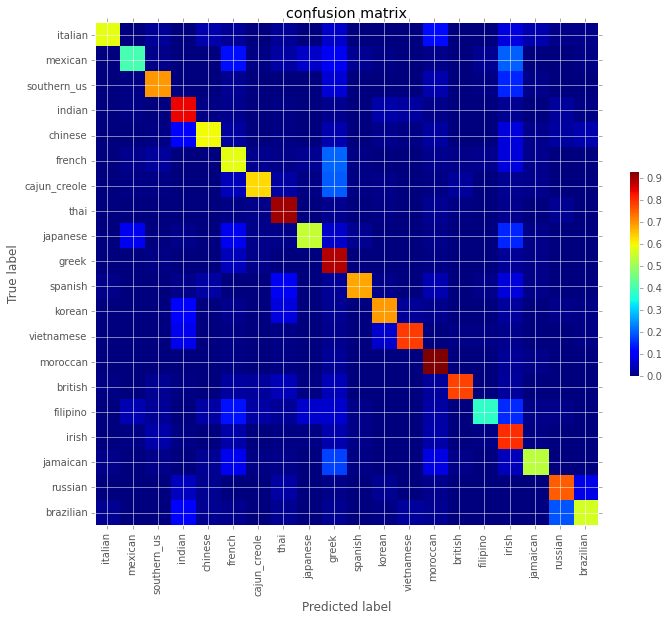

In [87]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 10))

cm = confusion_matrix(y_test, logistic.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = df_train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here, we see that some cuisines are really well predicted (Moroccan, Thai, Indian) while some suffer from confusion (Greek is often predicted as other cuisines, same with irish).

Another way to look at the results is the classification report from scikit-learn:

In [88]:
from sklearn.metrics import classification_report

In [89]:
y_pred = logistic.predict(X_test)
print(classification_report(y_test, y_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.83      0.58      0.69       103
     mexican       0.64      0.41      0.50       185
 southern_us       0.77      0.70      0.73       325
      indian       0.80      0.84      0.82       522
     chinese       0.75      0.60      0.67       150
      french       0.57      0.58      0.58       512
cajun_creole       0.77      0.63      0.69       226
        thai       0.86      0.90      0.88       624
    japanese       0.63      0.55      0.59       119
       greek       0.80      0.89      0.84      1581
     spanish       0.75      0.68      0.72        94
      korean       0.80      0.69      0.74       287
  vietnamese       0.80      0.79      0.80       156
    moroccan       0.90      0.93      0.91      1249
     british       0.87      0.78      0.82       176
    filipino       0.61      0.38      0.47        97
       irish       0.70      0.80      0.75       852
    jamaican       0.67    

This allows use to see the different precision measurements (accuracy, recall, f1 score) all in a single place.

From the previous analyses, we can come up with a number of ways of how to improve aspects of our machine learning and reach better classification results.

# Conclusions 

In this post, we've gone through different stages of machine learning: we first explored the data in depth that came with the challenge and then went on to train a model, whose results we tried to analyze. It's not clear from the results what we can easily improve in our classification, but it gives us quite a lot of information to analyze.